In [1]:
import pandas as pd
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('train.csv')
df.dropna(inplace=True)
df = df.sample(30000,random_state=1)

In [4]:
column_black=[f'n{i}' for i in range(15)]+['id','issueDate','applicationType','title','employmentTitle','regionCode','postCode']
df.drop(column_black,axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 605537 to 134351
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loanAmnt            30000 non-null  float64
 1   term                30000 non-null  int64  
 2   interestRate        30000 non-null  float64
 3   installment         30000 non-null  float64
 4   grade               30000 non-null  object 
 5   subGrade            30000 non-null  object 
 6   employmentLength    30000 non-null  object 
 7   homeOwnership       30000 non-null  int64  
 8   annualIncome        30000 non-null  float64
 9   verificationStatus  30000 non-null  int64  
 10  isDefault           30000 non-null  int64  
 11  purpose             30000 non-null  int64  
 12  dti                 30000 non-null  float64
 13  delinquency_2years  30000 non-null  float64
 14  ficoRangeLow        30000 non-null  float64
 15  ficoRangeHigh       30000 non-null  float64
 16

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['grade']=le.fit_transform(df['grade'])
df['subGrade']=le.fit_transform(df['subGrade'])
df.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,earliesCreditLine,policyCode
605537,29500.0,3,10.99,965.66,1,7,7 years,0,150000.0,1,0,0,11.23,0.0,685.0,689.0,9.0,0.0,0.0,13042.0,59.8,15.0,1,Nov-1995,1.0
775571,15000.0,5,7.89,303.36,0,4,10+ years,1,72000.0,0,0,0,17.92,0.0,770.0,774.0,11.0,0.0,0.0,3307.0,33.4,22.0,0,Jul-2001,1.0
426193,16000.0,3,8.18,502.72,1,5,6 years,0,72000.0,2,0,2,6.10,0.0,660.0,664.0,3.0,0.0,0.0,0.0,0.0,15.0,0,Oct-2000,1.0
263213,12000.0,3,9.99,387.15,1,7,3 years,1,42000.0,2,0,0,18.63,1.0,675.0,679.0,11.0,0.0,0.0,8424.0,53.0,28.0,0,Dec-2001,1.0
705873,6025.0,3,16.02,211.89,2,14,2 years,1,79000.0,1,1,6,8.16,0.0,750.0,754.0,8.0,0.0,0.0,790.0,4.8,8.0,0,Aug-2013,1.0


In [6]:
df['earliesCreditLine'] = df['earliesCreditLine'].apply(lambda s: int(s[-4:]))
df.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,earliesCreditLine,policyCode
605537,29500.0,3,10.99,965.66,1,7,7 years,0,150000.0,1,0,0,11.23,0.0,685.0,689.0,9.0,0.0,0.0,13042.0,59.8,15.0,1,1995,1.0
775571,15000.0,5,7.89,303.36,0,4,10+ years,1,72000.0,0,0,0,17.92,0.0,770.0,774.0,11.0,0.0,0.0,3307.0,33.4,22.0,0,2001,1.0
426193,16000.0,3,8.18,502.72,1,5,6 years,0,72000.0,2,0,2,6.10,0.0,660.0,664.0,3.0,0.0,0.0,0.0,0.0,15.0,0,2000,1.0
263213,12000.0,3,9.99,387.15,1,7,3 years,1,42000.0,2,0,0,18.63,1.0,675.0,679.0,11.0,0.0,0.0,8424.0,53.0,28.0,0,2001,1.0
705873,6025.0,3,16.02,211.89,2,14,2 years,1,79000.0,1,1,6,8.16,0.0,750.0,754.0,8.0,0.0,0.0,790.0,4.8,8.0,0,2013,1.0


In [7]:
df['employmentLength'] = df['employmentLength'].map(
        {'1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8,
         '9 years': 9, '10+ years': 10, '< 1 year': 0})
df.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentLength,homeOwnership,annualIncome,verificationStatus,isDefault,purpose,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,earliesCreditLine,policyCode
605537,29500.0,3,10.99,965.66,1,7,7,0,150000.0,1,0,0,11.23,0.0,685.0,689.0,9.0,0.0,0.0,13042.0,59.8,15.0,1,1995,1.0
775571,15000.0,5,7.89,303.36,0,4,10,1,72000.0,0,0,0,17.92,0.0,770.0,774.0,11.0,0.0,0.0,3307.0,33.4,22.0,0,2001,1.0
426193,16000.0,3,8.18,502.72,1,5,6,0,72000.0,2,0,2,6.10,0.0,660.0,664.0,3.0,0.0,0.0,0.0,0.0,15.0,0,2000,1.0
263213,12000.0,3,9.99,387.15,1,7,3,1,42000.0,2,0,0,18.63,1.0,675.0,679.0,11.0,0.0,0.0,8424.0,53.0,28.0,0,2001,1.0
705873,6025.0,3,16.02,211.89,2,14,2,1,79000.0,1,1,6,8.16,0.0,750.0,754.0,8.0,0.0,0.0,790.0,4.8,8.0,0,2013,1.0


In [8]:
Y=df['isDefault']
X=df.drop('isDefault',axis=1)

In [9]:
model = XGBClassifier()
model.fit(X, Y)
model.feature_importances_

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:26:46] WARNING: D:\Build\xgboost\xgboost-1.3.3.git\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.02409948, 0.07138789, 0.02561198, 0.02490968, 0.2752579 ,
       0.20003109, 0.02202368, 0.02993597, 0.02525343, 0.02465919,
       0.01992217, 0.02442665, 0.019796  , 0.02304057, 0.        ,
       0.02351353, 0.02427981, 0.02495658, 0.02502912, 0.0231053 ,
       0.02148194, 0.02456287, 0.02271509, 0.        ], dtype=float32)

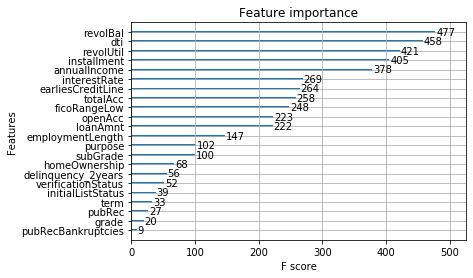

In [10]:
plot_importance(model)